# Percobaan Dengan Deep Neural Network




Mengimpor Library dan Memeriksa Versi Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


Membuat Fungsi Data Series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Waktu") 
    plt.ylabel("Nilai")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Membuat Seriesnya
series = baseline + trend(time, slope) + seasonality(time,
                                                     period=365, 
                                                     amplitude=amplitude)
# Menambahkan noise
series += noise(time, noise_level, seed=42)

Membagi Dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Membuat Visualisasi

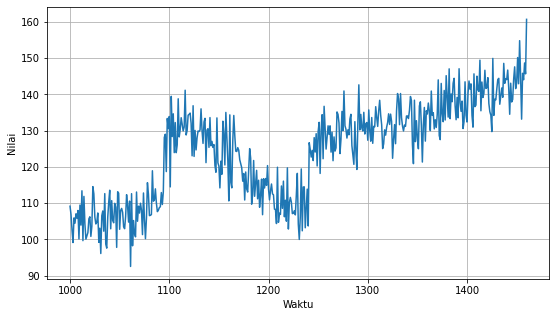

In [ ]:
plt.figure(figsize=(9, 5))
plot_series(time_valid, x_valid)

Membuat Fungsi Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: 
                                                (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Membuat Model dengan DNN

In [ ]:
#Memanggil Fungsi Windowed Dataset
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

#Membuat DNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#Menampilkan simpulan model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


Mentraining Model

In [ ]:
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, 
                                                momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

Membuat Visualisasi hasil prediksi

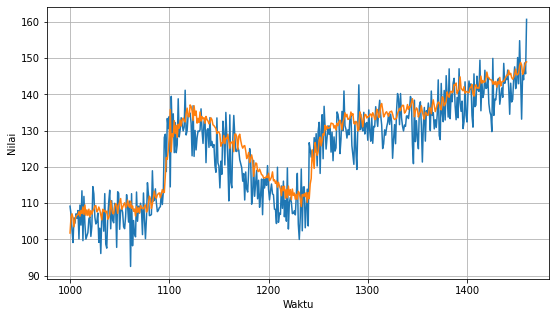

In [ ]:
prediksi = []
for time in range(len(series) - window_size):
  prediksi.append(model.predict(series[time:time + window_size]
                                [np.newaxis]))

prediksi = prediksi[split_time-window_size:]
Hasil = np.array(prediksi)[:, 0, 0]

plt.figure(figsize=(9, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, Hasil)

Mengukur hasil MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, Hasil).numpy()

5.076333

# Memperbaiki Model dengan Deep Neural Network

Model Sebelumnya

In [ ]:
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


Menambahkan Callback dan Training Model

In [ ]:
#Membuat callback learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#Membuat optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

#Mengcompile Model
model.compile(loss="mse", optimizer=optimizer)

#Mentraining Model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

Memvisualisasikan Kecepatan Epoch

(1e-08, 0.001, 0.0, 300.0)

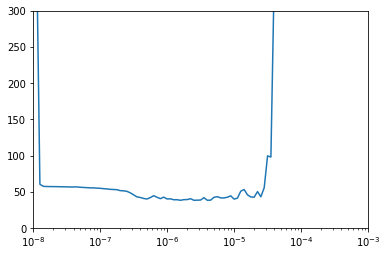

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

Membuat Model Baru

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, 
                                    momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

Memvisualisasikan Hasil Loss

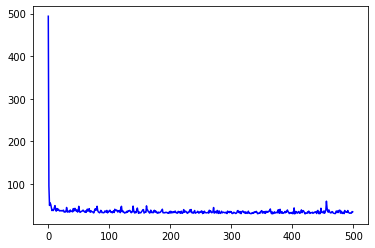

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[45.08787536621094, 49.175777435302734, 39.384674072265625, 36.1395263671875, 42.389678955078125, 38.02522659301758, 40.991172790527344, 39.96600341796875, 37.08125305175781, 36.59220504760742, 37.2800407409668, 37.75959396362305, 36.81684494018555, 36.46393585205078, 37.90199661254883, 38.45921325683594, 34.0770378112793, 34.20182800292969, 35.41101837158203, 34.47500991821289, 44.80937194824219, 37.89891815185547, 33.69306564331055, 36.084712982177734, 35.7650260925293, 33.87516784667969, 38.79440689086914, 35.49900436401367, 35.976402282714844, 35.54082489013672, 34.49530029296875, 42.146915435791016, 36.73497772216797, 42.21623992919922, 42.469764709472656, 38.802791595458984, 35.96334457397461, 38.97210693359375, 34.03580856323242, 35.9126091003418, 47.513389587402344, 37.39836883544922, 33.22374725341797, 34.203399658203125, 35.32948303222656, 36.22809600830078, 36.6448974609375, 38.63880157470703, 36.613563537597656, 35.309017181396484, 33.71573257446289, 36.708778381347656, 33.

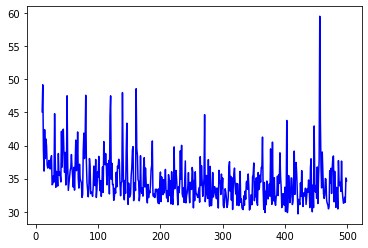

In [ ]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

Memvisualisasikan Hasil Prediksi

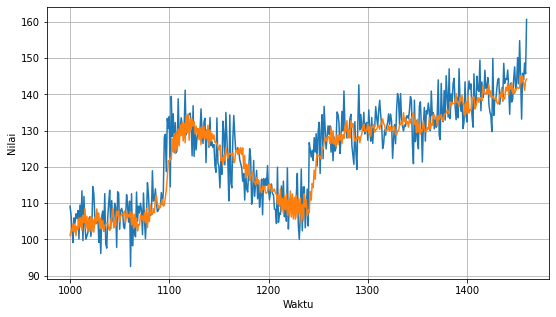

In [ ]:
prediksi = []
for time in range(len(series) - window_size):
  prediksi.append(model.predict(series[time:time + window_size]
                                [np.newaxis]))

prediksi = prediksi[split_time-window_size:]
Hasil = np.array(prediksi)[:, 0, 0]

plt.figure(figsize=(9, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, Hasil)

Mengukur Hasil MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, Hasil).numpy()

4.7271905